# Sentimental Analysis of Product based reviews 

###         Importing the required packages

In [1]:
#!pip install wordcloud
#!pip install xgboost

In [2]:
import os
import time
Time_Start=time.time()
# ignore warinings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np    # linear algebra

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

from sklearn.model_selection import  train_test_split 

from sklearn.metrics import roc_curve, auc

from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC

from sklearn.naive_bayes import MultinomialNB , BernoulliNB

from sklearn.ensemble import RandomForestClassifier 

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

from wordcloud import WordCloud

from collections import Counter

from pylab import rcParams

import statistics 

import string

import re

import nltk

from nltk.corpus import words

from nltk.stem.snowball import SnowballStemmer

from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords

In [4]:
# current working directory
print(os.getcwd(),"\n")

C:\Users\Rithish Miryala\Downloads\mini proj build 



In [5]:
# Input data files are available in the read-only "dataset/" directory
# For example, running below cell will list all files under the dataset directory

## Reading and Organising the Dataset

In [6]:
# collecting all the datasets and concatenating them to a single dataframe
datasets=[]
for dirname, _, filenames in os.walk('dataset/'):
    for filename in filenames:
        filepath=os.path.join(dirname, filename)
        print(filepath)
        datasets.append(filepath)

# creating a empty dataframe
amazon_data=pd.DataFrame()

# adding all the datasets to the amazon_data dataframe
for i in datasets:
    amazon_data=pd.concat([amazon_data,pd.read_csv(i)])

print("\nShape of dataset : ",amazon_data.shape)

dataset/Amazon_Unlocked_Mobile.csv

Shape of dataset :  (413840, 6)


### Data cleaning

In [7]:
# information about dataframe 
print(amazon_data.info())
print("\n\nNull values in each row  :\n\n",amazon_data.isna().sum())
print("\nTotal null values in dataset  :  ",amazon_data.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB
None


Null values in each row  :

 Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            62
Review Votes    12296
dtype: int64

Total null values in dataset  :   83462


In [8]:
# Removinging all the rows with null values
print("Shape of dataset before dropping null  :  ",amazon_data.shape )
amazon_data=amazon_data.dropna(axis =0)

print("\nShape of dataset after dropping null   :  ",amazon_data.shape ,"\n")
print(amazon_data.head())
print(amazon_data.tail())

Shape of dataset before dropping null  :   (413840, 6)

Shape of dataset after dropping null   :   (334335, 6) 

                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  
0       5  I feel so LUCKY to have found this used (phone...           1.0  
1       4  nice phone, nice up grade from my pantach revu...           0.0  
2       5                                       Very pleased           0.0  
3       4  It works good but it goes slow sometimes but i...           0.0  
4       4  Great phone to replace my lost phone. Th

In [9]:
print("Rating values in dataset are : ", sorted(amazon_data.Rating.unique()))

Rating values in dataset are :  [1, 2, 3, 4, 5]


In [10]:
print("Features are \n",amazon_data.columns)

Features are 
 Index(['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews',
       'Review Votes'],
      dtype='object')


In [11]:
# statistics of the dataframe
print("Features are \n",amazon_data.describe())

Features are 
                Price         Rating   Review Votes
count  334335.000000  334335.000000  334335.000000
mean      222.585019       3.824888       1.474515
std       283.139353       1.541203       9.217348
min         1.730000       1.000000       0.000000
25%        75.410000       3.000000       0.000000
50%       139.000000       5.000000       0.000000
75%       264.100000       5.000000       1.000000
max      2598.000000       5.000000     645.000000


In [12]:
# here the target variable is Rating
# we are dealing with reviews whether they are positive or negative
# and also ratings to compare with predicted rating value and get the accuracy score
# so we consider only reviews and rating to be features for the dataframe
amazon_data=amazon_data[["Reviews","Rating"]] 
amazon_data.head()

,Reviews,Rating
0,I feel so LUCKY to have found this used (phone...,5
1,"nice phone, nice up grade from my pantach revu...",4
2,Very pleased,5
3,It works good but it goes slow sometimes but i...,4
4,Great phone to replace my lost phone. The only...,4


In [13]:
# spliting dataframe as positive and negative dataframes 
# considering 4,5 rating as positive review 1,2 as negative review

Value Count graph for each rating


<AxesSubplot:>

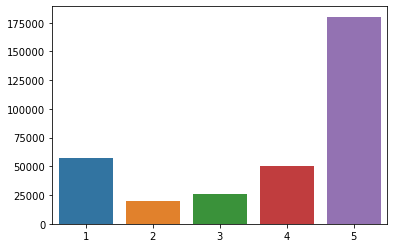

In [14]:
print("Value Count graph for each rating")
sns.barplot(x=amazon_data.Rating.value_counts().index,y=amazon_data.Rating.value_counts().values)

In [15]:
# function to calculate time taken 
def calcTime(startTime):
    endTime=time.time()
    Time=(endTime-startTime)
    return str(round(Time/60.0,4))+" min  or  "+str(round(Time,4))+" sec"

## Data Preprocessing

In [16]:
# removing some required words from stopwords 
STOPWORDS=stopwords.words("english") 
print("Stop words  ::: ",STOPWORDS)

Stop words  :::  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same'

In [17]:
# required words are
required=["not" ,"no" ,"nor"]  #,"out","most","too","very"

STOPWORDS=list(set(STOPWORDS)-set(required))
type(set(STOPWORDS))
print("Final Stopwords  :::",STOPWORDS)

Final Stopwords  ::: ["hasn't", "you'll", 'what', 'same', 'weren', 'yourselves', 'shouldn', 'and', 'so', 'doing', 'until', 'm', 'each', 'my', 'once', 'as', 'because', 'y', "don't", 'aren', "couldn't", 'him', "she's", 'the', 't', "should've", 'were', "wasn't", "you've", 'few', 're', 'of', "shouldn't", "didn't", 'all', 'herself', 'wouldn', 'can', 'his', "needn't", "you'd", 'he', 'them', 'on', 'for', 'down', "aren't", 'an', 'or', 'does', 'a', 'be', 'should', 'isn', 'at', "doesn't", 'won', 'before', 'mightn', 'most', 'was', 'couldn', 'hadn', 'those', 'they', 'is', 'there', 'when', 'over', 'these', 'theirs', 'why', 'doesn', 'd', 'off', 'will', 'in', 'wasn', 'themselves', 'while', "hadn't", 'that', 'above', 'did', 'from', 'after', 'how', 'such', 'ourselves', "it's", 'any', 'into', 'other', 'o', 'i', 'where', 'only', 'having', 'out', 'mustn', 'with', 'again', "weren't", 'through', 'which', 'are', 'if', 'shan', 'we', 's', 'own', 'by', 'ma', "mightn't", 'didn', "isn't", 'about', "wouldn't", 'th

In [18]:
# downloading words in english dictionary 
nltk.download('words')

# downloading wordnet for Lemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package words to C:\Users\Rithish
[nltk_data]     Miryala\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Rithish
[nltk_data]     Miryala\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
setofwords = set(words.words())
print("some of the words in dictionary    :::\n",list(setofwords)[:50])

some of the words in dictionary    :::
 ['dermatauxe', 'disobligation', 'maxilloturbinal', 'Teutophile', 'tee', 'Newichawanoc', 'reflorescent', 'ventilating', 'mammothrept', 'bowery', 'polytrochal', 'Phidiac', 'acaleph', 'bewhistle', 'athelia', 'rubbler', 'exploitative', 'scrippage', 'profess', 'mopingly', 'scoptophilic', 'hurting', 'avulse', 'crouch', 'preceptoral', 'Baltic', 'beaverteen', 'stenostomia', 'baccated', 'gentlemanlike', 'longilingual', 'rerun', 'countor', 'impeditive', 'Nycteris', 'absurd', 'odist', 'troutlet', 'bordering', 'skirl', 'Treponema', 'Omaha', 'uncular', 'skibby', 'Oxytropis', 'embellish', 'photometric', 'Aplysia', 'gneissoid', 'regrip']


In [20]:
lemmatizer = WordNetLemmatizer()

def deEmojify(inputString):#to remove emojis in the text.
    try:
        return inputString.encode('ascii', 'ignore').decode('ascii') 
    except:
        return inputString
   #most common unnecessary words. eg is, he, that, etc

def filter_text(text):
    text=text.strip('\n')
    text=deEmojify(str(text))
    text_cleaned=re.sub(' +', ' ', text) # remove extra white spaces
    
    text_cleaned=text_cleaned.lower() # converting to lowercase
    tokens=text_cleaned.split(" ")
    
    ftokens=[]
    for token in tokens:
        if token!='':
            if "n't" in token:
                ftokens.append('not')
            elif token not in STOPWORDS:
                ftokens.append(token)
    tokens=[]
    for token in ftokens:
        st=[]
        for x in token:
            if x not in string.punctuation:
                st.append(x)
        if len(st)!=0:
            tokens.append(''.join([tkn for tkn in st]) )
                
                    
    tokens=[token for token in tokens if token.isalpha()]  # only alphabets
    tokens=[token for token in tokens if token in setofwords] # only words from english dictionary 
    tokens=[lemmatizer.lemmatize(token) for token in tokens] 
    
    # Taking only those words which are not stopwords
    text_cleaned = ' '.join([str(token) for token in tokens]) 
    
    return text_cleaned
print (filter_text("phone is not doing good"))

phone not good


In [21]:
# considering equal rows from negative and positive dataframe each 
# to get equal amount of model training for positive and negative reviews

minimumCount=20000

# add an extra feature as 'r' to consider 4,5 rating as 1 and 1,2 rating as 0 
# here 0,1 indicates the rating as negative and posite respectively

In [22]:
pos_reviews=[]
a=time.time()
for rows in amazon_data[amazon_data["Rating"].isin([4,5])].Reviews:
    if(len(pos_reviews)==minimumCount):
        break
    rows=filter_text(rows)
    if(rows!=''):
        pos_reviews.append(rows)

amazon_data_pos=pd.DataFrame(list(zip(pos_reviews,[1]*minimumCount)),columns=['Reviews','r'])
print(amazon_data_pos)
print("Time taken to get positive reviews :::",calcTime(a))

                                                 Reviews  r
0      feel lucky found used phone u not used hard al...  1
1      nice phone nice grade revue clean set easy set...  1
2            work good go slow sometimes good phone love  1
3      great phone replace lost phone thing volume bu...  1
4      originally galaxy sprint return back epic spri...  1
...                                                  ... ..
19995  pretty skeptical read phone got one two small ...  1
19996                                         nice price  1
19997                    extremely fast shipping product  1
19998  fast received order phone working fine small m...  1
19999                                               love  1

[20000 rows x 2 columns]
Time taken to get positive reviews ::: 0.0774 min  or  4.6423 sec


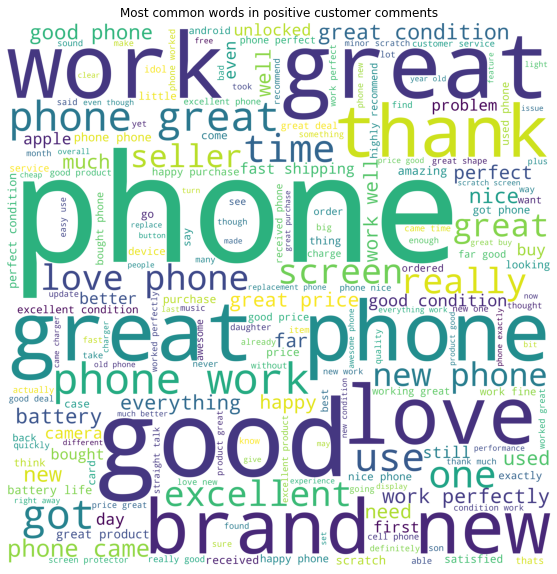

Time taken to build positive wordcloud ::: 0.8483 min  or  50.8992 sec


In [23]:
a=time.time()
wordcloud = WordCloud(height=4000, width=4000, background_color='white')
wordcloud = wordcloud.generate(' '.join(pos_reviews))
plt.figure( figsize=(20,10))
plt.imshow(wordcloud)
plt.title("Most common words in positive customer comments")
plt.axis('off')
plt.show()
print("Time taken to build positive wordcloud :::",calcTime(a))

In [24]:
neg_reviews=[]
a=time.time()
for rows in amazon_data[amazon_data["Rating"].isin([1,2])] .Reviews:
    if(len(neg_reviews)==minimumCount):
        break
    rows=filter_text(rows)
    if(rows!=''):
        neg_reviews.append(rows)

amazon_data_neg=pd.DataFrame(list(zip(neg_reviews,[0]*minimumCount)),columns=['Reviews','r'])
print(amazon_data_neg)
print("Time taken to get negative reviews :::",calcTime(a))

                                                 Reviews  r
0      already phone know stated used dang not state ...  0
1      charging port loose got in new battery well la...  0
2      phone good not stay buy new battery still not ...  0
3      really disappointed phone service phone went w...  0
4      phone not working got phone one thing card slo...  0
...                                                  ... ..
19995  good afternoon brought cell charger not recommend  0
19996  card in thing practically unusable play would ...  0
19997  dash android unlocked piece cheap not worried ...  0
19998  hi want say seller dear seller bad many use ph...  0
19999  overall cool phone got defective one memory small  0

[20000 rows x 2 columns]
Time taken to get negative reviews ::: 0.1444 min  or  8.6639 sec


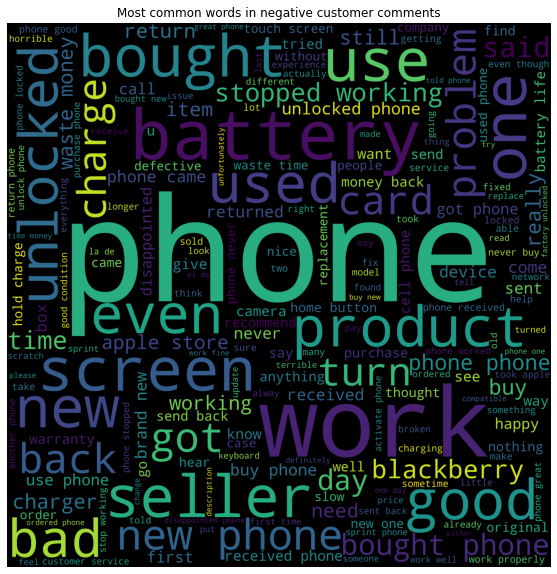

Time taken to build negative wordcloud ::: 0.9357 min  or  56.1394 sec


In [25]:
a=time.time()
wordcloud = WordCloud(height=4000, width=4000,background_color='white')
wordcloud = wordcloud.generate(' '.join(neg_reviews))
plt.figure( figsize=(20,10))
plt.imshow(wordcloud)
plt.title("Most common words in negative customer comments")
plt.axis('off')
plt.show()
print("Time taken to build negative wordcloud :::",calcTime(a))

In [26]:
print("Shape of complete dataframe : ",amazon_data.shape)
print("Shape of positive dataframe : ",amazon_data_pos.shape)
print("Shape of negative dataframe : ",amazon_data_neg.shape)

Shape of complete dataframe :  (334335, 2)
Shape of positive dataframe :  (20000, 2)
Shape of negative dataframe :  (20000, 2)


Time taken    :::  0.0142 min  or  0.8536 sec


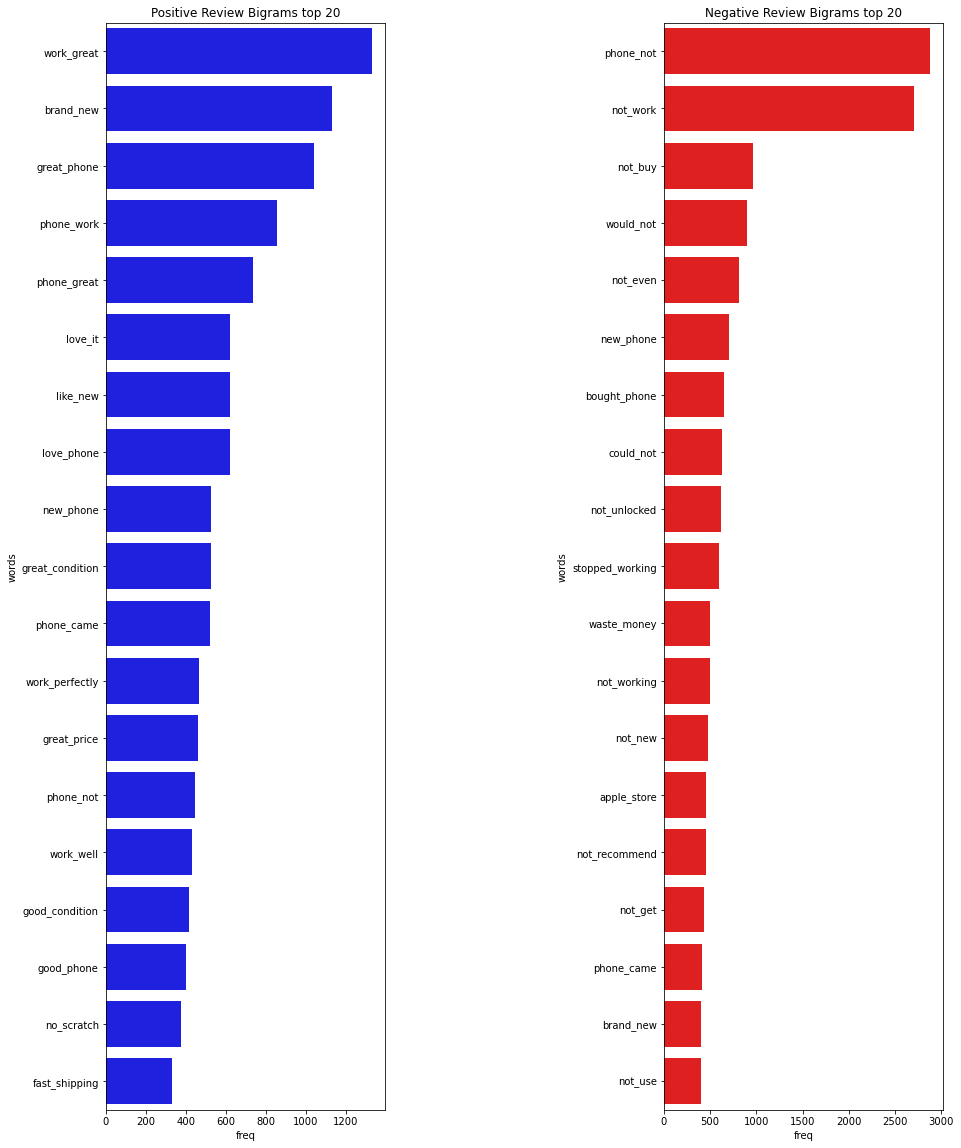

In [27]:
def getMostCommon(reviews_list,topn=20):
    reviews=" ".join(reviews_list)
    tokenised_reviews=reviews.split(" ")
    freq_counter=Counter(tokenised_reviews)
    return freq_counter.most_common(topn)

def generateNGram(text,n):
    tokens=text.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ["_".join(ngram) for ngram in ngrams]


def plotMostCommonWords(reviews_list,topn=30,title="Common Review Words",color="blue",axis=None): #default number of words is given as 30
    top_words=getMostCommon(reviews_list,topn=topn)
    data=pd.DataFrame()
    data['words']=[val[0] for val in top_words]
    data['freq']=[val[1] for val in top_words]
    data=data[data['words']!='']    
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title+" top "+str(topn))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title+" top "+str(topn))
        
        

a=time.time()
positive_reviews_bigrams=[" ".join(generateNGram(review,2)) for review in pos_reviews]
negative_reviews_bigrams=[" ".join(generateNGram(review,2)) for review in neg_reviews]

rcParams['figure.figsize'] = 15,20
fig,ax=plt.subplots(1,2)
fig.subplots_adjust(wspace=1)
plotMostCommonWords(positive_reviews_bigrams,20,'Positive Review Bigrams',axis=ax[0])
plotMostCommonWords(negative_reviews_bigrams,20,'Negative Review Bigrams',color="red",axis=ax[1])
print("Time taken    ::: ",calcTime(a))

                                                 Reviews  r
0      feel lucky found used phone u not used hard al...  1
1      nice phone nice grade revue clean set easy set...  1
2            work good go slow sometimes good phone love  1
3      great phone replace lost phone thing volume bu...  1
4      originally galaxy sprint return back epic spri...  1
...                                                  ... ..
19995  good afternoon brought cell charger not recommend  0
19996  card in thing practically unusable play would ...  0
19997  dash android unlocked piece cheap not worried ...  0
19998  hi want say seller dear seller bad many use ph...  0
19999  overall cool phone got defective one memory small  0

[40000 rows x 2 columns]


<AxesSubplot:>

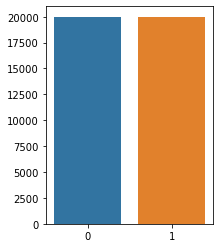

In [28]:
# merging two dataframes to single dataframe as filtered dataframe
amazon_data_filtered =pd.concat([amazon_data_pos,amazon_data_neg])
print(amazon_data_filtered)
plt.figure(figsize=(3,4))
sns.barplot(x=amazon_data_filtered.r.value_counts().index,y=amazon_data_filtered.r.value_counts().values)

In [29]:
# from sklearn.model_selection import train_test_split
# X_train_data, x_test_data,Y_train_data,y_test_data=train_test_split(amazon_data_filtered["Reviews"],amazon_data_filtered["r"],test_size=0.2,shuffle=True)

testsize=int(0.2 * len(amazon_data_pos))
print("Test size is :::",testsize)
amazon_data_test=pd.concat([amazon_data_pos[:testsize],amazon_data_neg[:testsize]])
amazon_data_train=pd.concat([amazon_data_pos[testsize:],amazon_data_neg[testsize:]])


X_train_data , x_test_data = amazon_data_train["Reviews"],amazon_data_test["Reviews"]
Y_train_data , y_test_data = amazon_data_train["r"],amazon_data_test["r"]

print("total shape of dataframe : ",amazon_data_filtered.shape)
print("obtained rows of Y after split (train , test)  : (",Y_train_data.shape[0],",", y_test_data.shape[0],")")
print("obtained rows of X after split (train , test)  : (",X_train_data.shape[0],",", x_test_data.shape[0],")")
#print("sum =", sum((Y_train_data.shape[0],y_test_data.shape[0])))
print( amazon_data_test.r.value_counts(),amazon_data_train.r.value_counts(),"\n", sep="\n\n")
print(Y_train_data.value_counts(),"\n\n")
print( y_test_data.value_counts(),"\n\n")
print(X_train_data.value_counts(),"\n\n")
print( x_test_data.value_counts(),"\n\n")

Test size is ::: 4000
total shape of dataframe :  (40000, 2)
obtained rows of Y after split (train , test)  : ( 32000 , 8000 )
obtained rows of X after split (train , test)  : ( 32000 , 8000 )
1    4000
0    4000
Name: r, dtype: int64

1    16000
0    16000
Name: r, dtype: int64



1    16000
0    16000
Name: r, dtype: int64 


1    4000
0    4000
Name: r, dtype: int64 


good                                                                                                                                                                                                                                                                            535
great                                                                                                                                                                                                                                                                           305
excellent                                                                

In [30]:
#tfidf Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf_vector=TfidfVectorizer(stop_words= STOPWORDS)

tfidf_vector.fit(X_train_data)
print(tfidf_vector.get_feature_names()[:20])

print(tfidf_vector.get_feature_names()[-28])


['abandoned', 'ability', 'able', 'abnormal', 'abort', 'abrasion', 'abreast', 'abroad', 'absent', 'absolute', 'absolutely', 'abstinence', 'absurd', 'abuse', 'abut', 'abysmal', 'acceder', 'accelerate', 'accelerated', 'accent']
wud


In [31]:
X_train_data_new=tfidf_vector.transform(X_train_data)

print(X_train_data_new.shape)

x_test_data_new=tfidf_vector.transform(x_test_data)

(32000, 5347)


In [32]:
print(X_train_data_new,Y_train_data)
# xczx

  (0, 5158)	0.25274172153829705
  (0, 4350)	0.36504392130710783
  (0, 4066)	0.38017009795597867
  (0, 3334)	0.08957149953044698
  (0, 3075)	0.10154555981277487
  (0, 2980)	0.2334581622507872
  (0, 2739)	0.1995052225541982
  (0, 2609)	0.3264521964127803
  (0, 2543)	0.24099415920284561
  (0, 2514)	0.2986404768311008
  (0, 2017)	0.15982963117892462
  (0, 1547)	0.2926248389165624
  (0, 931)	0.19942468208914146
  (0, 527)	0.3753868482544097
  (1, 5303)	0.19644072450565628
  (1, 5053)	0.4444830985291553
  (1, 4979)	0.21290032319669153
  (1, 4081)	0.21075886770137986
  (1, 3334)	0.09416326191392223
  (1, 3279)	0.2833104047365982
  (1, 3250)	0.31526825271471265
  (1, 3075)	0.10675115628265132
  (1, 2701)	0.26767674011656545
  (1, 2001)	0.5679447003716571
  (1, 1980)	0.20167790380364706
  :	:
  (31998, 4612)	0.20643666973247685
  (31998, 4427)	0.21027597923160996
  (31998, 4081)	0.2673334897067672
  (31998, 4008)	0.16739409319466264
  (31998, 3863)	0.27308835823060945
  (31998, 3802)	0.19829552

In [33]:
def modelAnalyzer(classifierName):
    print("\n\n",classifierName," Classifier",sep="") 
    print("Accuracy                :::", accuracy[classifierName])
    #Generating Confusion matrix
    print("Confusion matrix        :::")
    print(confusion_matrix(y_test_data, predictions[classifierName]))

    #Calculating Precision, Recall and Measure
    print("\nclassification report   :::")
    print(classification_report(y_test_data, predictions[classifierName], target_names=["Positive", "Negative"]))

    #Generating ROC curve
    false_positive, true_positive,_= roc_curve(y_test_data,predictions[classifierName])
    plt.figure(figsize=(7,6))
    plt.title("Receiver operating characteristic curve")
    plt.plot(false_positive, true_positive)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()


predictions=dict()
accuracy=dict()
models=dict()



SVM classifier
Please be patient. This may take some time.
Train Started
Time taken to fit       ::: 2.1645 min  or  129.8714 sec
Time taken to predict   ::: 0.1504 min  or  9.0258 sec
Accuracy                ::: 0.8935


SVM Classifier
Accuracy                ::: 0.8935
Confusion matrix        :::
[[3760  240]
 [ 612 3388]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.86      0.94      0.90      4000
    Negative       0.93      0.85      0.89      4000

    accuracy                           0.89      8000
   macro avg       0.90      0.89      0.89      8000
weighted avg       0.90      0.89      0.89      8000



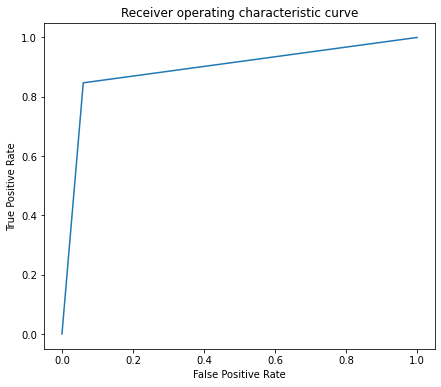

Overall time taken for SVM classifier ::: 2.3191 min  or  139.144 sec


In [34]:
#1. SVM classifier
print("\n\nSVM classifier") 
print("Please be patient. This may take some time.")
models["SVM"]=SVC()

#Train Model
print("Train Started")
aaa=time.time()
models["SVM"].fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions['SVM']=models["SVM"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

# Calculating model accuracy
accuracy['SVM']=accuracy_score(y_test_data, predictions['SVM'])
print("Accuracy                :::", accuracy['SVM'])

modelAnalyzer('SVM')
print("Overall time taken for SVM classifier :::",calcTime(aaa))



RandomForest Classifier
Please be patient. This may take some time
Train Started
Time taken to fit       ::: 0.3382 min  or  20.2904 sec
Time taken to predict   ::: 0.0061 min  or  0.366 sec
Accuracy                ::: 0.85325


RandomForest Classifier
Accuracy                ::: 0.85325
Confusion matrix        :::
[[3752  248]
 [ 926 3074]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.80      0.94      0.86      4000
    Negative       0.93      0.77      0.84      4000

    accuracy                           0.85      8000
   macro avg       0.86      0.85      0.85      8000
weighted avg       0.86      0.85      0.85      8000



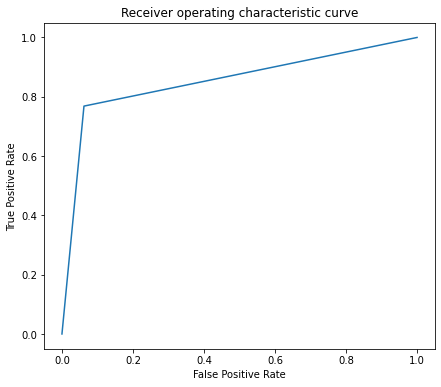

Overall time taken for RandomForest Classifier ::: 0.3481 min  or  20.8865 sec


In [35]:
#2. RandomForest Classifier

print("\n\nRandomForest Classifier") 
print("Please be patient. This may take some time")

models["RandomForest"]=RandomForestClassifier()
#Train Model
print("Train Started")
aaa=time.time()
models["RandomForest"].fit(X_train_data_new ,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions ["RandomForest"]=models["RandomForest"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["RandomForest"]=accuracy_score(y_test_data, predictions["RandomForest"])
print("Accuracy                :::", accuracy["RandomForest"])

modelAnalyzer("RandomForest")

print("Overall time taken for RandomForest Classifier :::",calcTime(aaa))



Multinomial Naive Bayes Classifier
Please be patient. This may take some time.
Train Started
Time taken to fit       ::: 0.0001 min  or  0.009 sec
Time taken to predict   ::: 0.0 min  or  0.001 sec
Accuracy                ::: 0.855375


Multinomial Naive Bayes Classifier
Accuracy                ::: 0.855375
Confusion matrix        :::
[[3740  260]
 [ 897 3103]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.81      0.94      0.87      4000
    Negative       0.92      0.78      0.84      4000

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.85      8000
weighted avg       0.86      0.86      0.85      8000



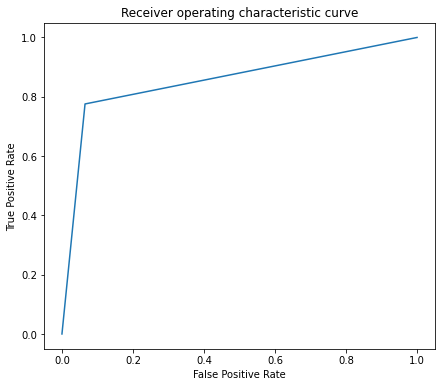

Overall time taken for Multinomial Naive Bayes Classifier::: 0.004 min  or  0.2395 sec


In [36]:
#3. Multinomial Naive Bayes Classifier

print("\n\nMultinomial Naive Bayes Classifier") 
print("Please be patient. This may take some time.")

models["Multinomial Naive Bayes"]=MultinomialNB()
#Train Model
print("Train Started")
aaa=time.time()
models["Multinomial Naive Bayes"].fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions["Multinomial Naive Bayes"]=models["Multinomial Naive Bayes"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["Multinomial Naive Bayes"]=accuracy_score(y_test_data, predictions["Multinomial Naive Bayes"])
print("Accuracy                :::", accuracy["Multinomial Naive Bayes"])

modelAnalyzer("Multinomial Naive Bayes")

print("Overall time taken for Multinomial Naive Bayes Classifier:::",calcTime(aaa))



Bernoulli Naive Bayes Classifier
Please be patient. This may take some time
Train Started
Time taken to fit       ::: 0.0003 min  or  0.016 sec
Time taken to predict   ::: 0.0001 min  or  0.004 sec
Accuracy                ::: 0.74025


Bernoulli Naive Bayes Classifier
Accuracy                ::: 0.74025
Confusion matrix        :::
[[2877 1123]
 [ 955 3045]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.75      0.72      0.73      4000
    Negative       0.73      0.76      0.75      4000

    accuracy                           0.74      8000
   macro avg       0.74      0.74      0.74      8000
weighted avg       0.74      0.74      0.74      8000



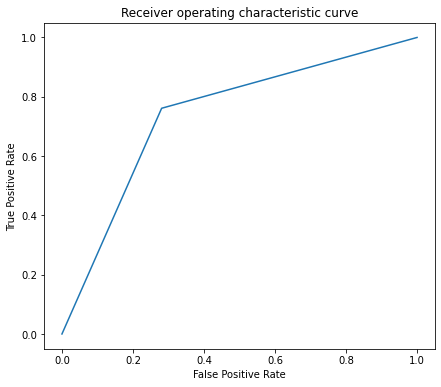

Overall time taken for Bernoulli Naive Bayes Classifier ::: 0.0043 min  or  0.257 sec


In [37]:
#4. Bernoulli Naive Bayes Classifier

print("\n\nBernoulli Naive Bayes Classifier") 
print("Please be patient. This may take some time")

models["Bernoulli Naive Bayes"]=BernoulliNB()
#Train Model
print("Train Started")
aaa=time.time()
models["Bernoulli Naive Bayes"].fit(X_train_data_new ,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions ["Bernoulli Naive Bayes"]=models["Bernoulli Naive Bayes"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["Bernoulli Naive Bayes"]=accuracy_score(y_test_data, predictions["Bernoulli Naive Bayes"])
print("Accuracy                :::", accuracy["Bernoulli Naive Bayes"])

modelAnalyzer("Bernoulli Naive Bayes")

print("Overall time taken for Bernoulli Naive Bayes Classifier :::",calcTime(aaa))



KNeighbors Classifier
Please be patient. This may take some time
Train Started
Time taken to fit       ::: 0.0001 min  or  0.007 sec
Time taken to predict   ::: 0.2025 min  or  12.1504 sec
Accuracy                ::: 0.6695


KNeighbors Classifier
Accuracy                ::: 0.6695
Confusion matrix        :::
[[1523 2477]
 [ 167 3833]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.90      0.38      0.54      4000
    Negative       0.61      0.96      0.74      4000

    accuracy                           0.67      8000
   macro avg       0.75      0.67      0.64      8000
weighted avg       0.75      0.67      0.64      8000



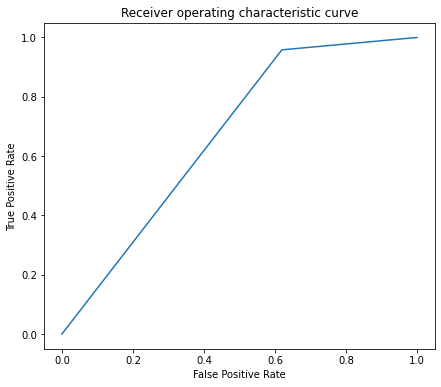

Overall time taken for RandomForest Classifier ::: 0.2101 min  or  12.6034 sec


In [38]:
#5. k-NN Classifier  

print("\n\nKNeighbors Classifier")
print("Please be patient. This may take some time")

models["KNeighbors"]= KNeighborsClassifier(n_neighbors=1)

#Train Model
print("Train Started")
aaa=time.time()
models["KNeighbors"].fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions["KNeighbors"] = models["KNeighbors"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["KNeighbors"]=accuracy_score(y_test_data, predictions["KNeighbors"])
print("Accuracy                :::", accuracy["KNeighbors"])

modelAnalyzer("KNeighbors")

print("Overall time taken for RandomForest Classifier :::",calcTime(aaa))



KNeighbors Classifier
Please be patient. This may take some time
Train Started
Time taken to fit       ::: 0.0122 min  or  0.7311 sec
Time taken to predict   ::: 0.0001 min  or  0.004 sec
Accuracy                ::: 0.88275


LogisticRegression Classifier
Accuracy                ::: 0.88275
Confusion matrix        :::
[[3747  253]
 [ 685 3315]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.85      0.94      0.89      4000
    Negative       0.93      0.83      0.88      4000

    accuracy                           0.88      8000
   macro avg       0.89      0.88      0.88      8000
weighted avg       0.89      0.88      0.88      8000



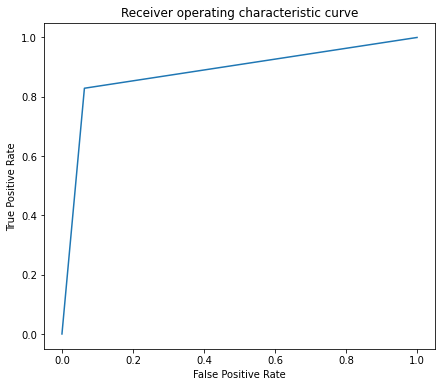

Overall time taken for LogisticRegression Classifier ::: 0.0179 min  or  1.0731 sec


In [39]:
#6.  Logistic Regression Classifier

print("\n\nKNeighbors Classifier")
print("Please be patient. This may take some time")

models['LogisticRegression'] = LogisticRegression()

#Train Model
print("Train Started")
aaa=time.time()
models['LogisticRegression'].fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions['LogisticRegression'] = models['LogisticRegression'].predict(x_test_data_new)

print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy['LogisticRegression']=accuracy_score(y_test_data, predictions['LogisticRegression'])
print("Accuracy                :::", accuracy['LogisticRegression'])

modelAnalyzer('LogisticRegression')

print("Overall time taken for LogisticRegression Classifier :::",calcTime(aaa))



Decision Tree Classifier
Please be patient. This may take some time
Train Started
Time taken to fit       ::: 0.0841 min  or  5.045 sec
Time taken to predict   ::: 0.0001 min  or  0.007 sec
Accuracy                ::: 0.831


DecisionTree Classifier
Accuracy                ::: 0.831
Confusion matrix        :::
[[3464  536]
 [ 816 3184]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.81      0.87      0.84      4000
    Negative       0.86      0.80      0.82      4000

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000



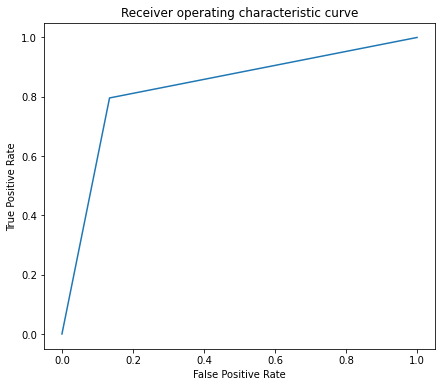

Overall time taken for DecisionTree Classifier ::: 0.0888 min  or  5.329 sec


In [40]:
#7. Decision Tree Classifier  
print("\n\nDecision Tree Classifier")
print("Please be patient. This may take some time")

models["DecisionTree"] = DecisionTreeClassifier()

#Train Model
print("Train Started")
aaa=time.time()
models["DecisionTree"].fit(X_train_data_new,Y_train_data)
print("Time taken to fit       :::",calcTime(aaa))

#Test Model
x=time.time()
predictions["DecisionTree"] = models["DecisionTree"].predict(x_test_data_new)
print("Time taken to predict   :::",calcTime(x))

#Calculating model accuracy
accuracy["DecisionTree"]=accuracy_score(y_test_data, predictions["DecisionTree"])
print("Accuracy                :::", accuracy["DecisionTree"])

modelAnalyzer("DecisionTree")

print("Overall time taken for DecisionTree Classifier :::",calcTime(aaa))

In [41]:
#!pip install xgboost

[15:53:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.4.0, the default evaluation metric used with the objective 'binary:logitraw' was changed from 'auc' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken to train     ::: 0.137 min  or  8.2173 sec
Time taken to predict   ::: 0.3097 min  or  18.5832 sec


XGB Classifier
Accuracy                ::: 0.86125
Confusion matrix        :::
[[3626  374]
 [ 736 3264]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.83      0.91      0.87      4000
    Negative       0.90      0.82      0.85      4000

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000



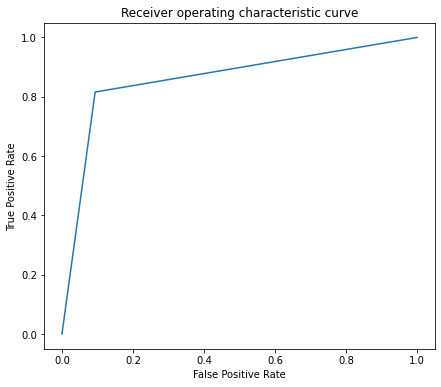

Overall time taken for XGBoost ::: 0.3091 min  or  18.5487 sec


In [42]:
#8. XGB Classifier 

xgb_train = xgb.DMatrix(X_train_data_new, Y_train_data)
xgb_test = xgb.DMatrix(x_test_data_new, y_test_data)

# Setting the Parameters of the Model
param = {'eta': 0.75,
         'max_depth': 50,
         'objective': 'binary:logitraw'}
# Training the Model
aaa=time.time()
models["XGB"]= xgb.train(param, xgb_train, num_boost_round = 30)
print("Time taken to train     :::",calcTime(aaa))

# Predicting using the Model
x==time.time()

predictedXgb=[]
for i in range(len(x_test_data)):
    predictedXgb.append(1 if models["XGB"].predict(xgb.DMatrix(x_test_data_new[i]))>0 else 0)
#     if(predictedXgb[-1]!=y_test_data.iloc[i]):
#         print(i,x_test_data.iloc[i][:100],(predictedXgb[-1],y_test_data.iloc[i]))
predictions["XGB"]= np.array(predictedXgb,dtype='int64')
print("Time taken to predict   :::",calcTime(x))

accuracy["XGB"]=accuracy_score(predictions["XGB"],y_test_data)

modelAnalyzer("XGB")

print("Overall time taken for XGBoost :::",calcTime(aaa))

In [43]:
accuracy.keys()

dict_keys(['SVM', 'RandomForest', 'Multinomial Naive Bayes', 'Bernoulli Naive Bayes', 'KNeighbors', 'LogisticRegression', 'DecisionTree', 'XGB'])

In [44]:
predictions

{'SVM': array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 'RandomForest': array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 'Multinomial Naive Bayes': array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 'Bernoulli Naive Bayes': array([0, 1, 1, ..., 0, 1, 0], dtype=int64),
 'KNeighbors': array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
 'LogisticRegression': array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 'DecisionTree': array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 'XGB': array([1, 1, 1, ..., 0, 0, 0], dtype=int64)}

Classifier Model
1: SVM
2: RandomForest
3: Multinomial Naive Bayes
4: Bernoulli Naive Bayes
5: KNeighbors
6: LogisticRegression
7: DecisionTree
8: XGB
Enter your choice
8
Details are


XGB Classifier
Accuracy                ::: 0.86125
Confusion matrix        :::
[[3626  374]
 [ 736 3264]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.83      0.91      0.87      4000
    Negative       0.90      0.82      0.85      4000

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000



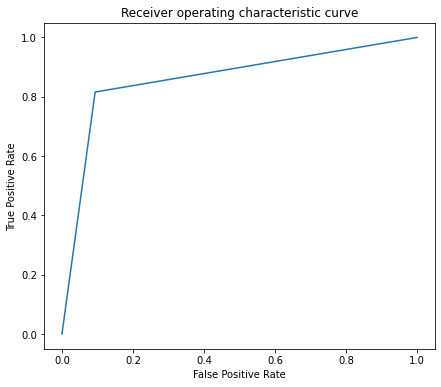

In [45]:
def analyze_each():
    def get_Details(choice): 
        print("Details are")
        modelAnalyzer(list(predictions.keys())[choice-1])
    print("Classifier Model") 
    i=1
    for classifier in predictions.keys():
        print(i,": ",classifier,sep="")
        i+=1
    print("Enter your choice")
    choice=int(input())
    get_Details(choice)
    
analyze_each()

In [46]:
def ensembget(index):
    l=[]
    for model in list(["SVM","LogisticRegression","RandomForest","XGB"]):
        l.append(predictions[model][index])

    return statistics.mode(l)

def get_ensemble_accuracy(y_data):

    yhats =[ensembget(xd) for xd in range(len(x_test_data))]
    return accuracy_score(y_data,yhats)

accuracy["Customised"]=get_ensemble_accuracy(y_test_data)
print("Overall Accuracy calculated using mode  :::", accuracy["Customised"])


Overall Accuracy calculated using mode  ::: 0.89175


In [52]:
def predict_rating(): 
    print("\n\nCustomer Review  :::")
    
    Inp_text=input()

    
    review=filter_text(Inp_text)
    new_test_transform = tfidf_vector.transform([review])
    
    def getPredictionMode(new_test_transform):
        l=[]
        for model in ["SVM","LogisticRegression","RandomForest"]:
            l.append(models[model].predict(new_test_transform)[0])
        l.append(1 if models["XGB"].predict(xgb.DMatrix(new_test_transform))[0]>0 else 0)

        return statistics.mode(l)


    Out_text="Positive" if getPredictionMode(new_test_transform) else "Negative"
    
    
    print ("Rating  :::", Out_text)
    print("\n")
predict_rating()




Customer Review  :::
phone is not good
Rating  ::: Negative






Calculating Accuracy of each model


                     Model  Accuracy
0                      SVM  0.893500
1             RandomForest  0.853250
2  Multinomial Naive Bayes  0.855375
3    Bernoulli Naive Bayes  0.740250
4               KNeighbors  0.669500
5       LogisticRegression  0.882750
6             DecisionTree  0.831000
7                      XGB  0.861250
8               Customised  0.891750


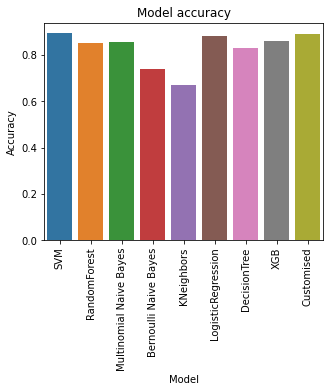

In [48]:
def compare_models():
    
    print("\n\nCalculating Accuracy of each model\n\n")
    
    #Model Accuracy Table    
    result_table=pd.DataFrame(list(accuracy.items()), columns=["Model", "Accuracy"]) 
    print (result_table)
    plt.figure(figsize =(5,4))   #

    sns.barplot(x="Model", y="Accuracy", data =result_table) 
    plt.title("Model accuracy")

    plt.xticks (rotation = 90)  #
    plt.show()
    

compare_models()


In [49]:
print("Overall time taken for Sentimental Analysis :::",calcTime(Time_Start))

Overall time taken for Sentimental Analysis ::: 6.949 min  or  416.9389 sec


Sentiment Analysis of Customer Reviews
1: Analyze the model
2: Predict the Rating
3: Compare the Models
4: Quit
1
Classifier Model
1: SVM
2: RandomForest
3: Multinomial Naive Bayes
4: Bernoulli Naive Bayes
5: KNeighbors
6: LogisticRegression
7: DecisionTree
8: XGB
Enter your choice
8
Details are


XGB Classifier
Accuracy                ::: 0.86125
Confusion matrix        :::
[[3626  374]
 [ 736 3264]]

classification report   :::
              precision    recall  f1-score   support

    Positive       0.83      0.91      0.87      4000
    Negative       0.90      0.82      0.85      4000

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000



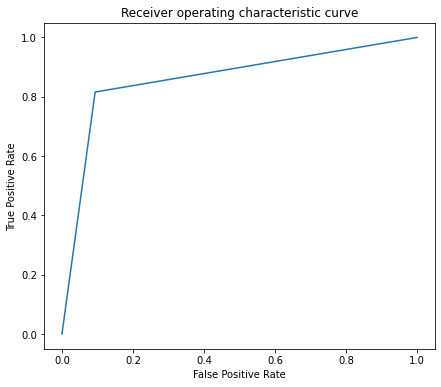

1: Analyze the model
2: Predict the Rating
3: Compare the Models
4: Quit
2
Customer Review  :::
phone is working
Rating  ::: Positive
1: Analyze the model
2: Predict the Rating
3: Compare the Models
4: Quit
3


Calculating Accuracy of each model


                     Model  Accuracy
0                      SVM  0.893500
1             RandomForest  0.853250
2  Multinomial Naive Bayes  0.855375
3    Bernoulli Naive Bayes  0.740250
4               KNeighbors  0.669500
5       LogisticRegression  0.882750
6             DecisionTree  0.831000
7                      XGB  0.861250
8               Customised  0.891750


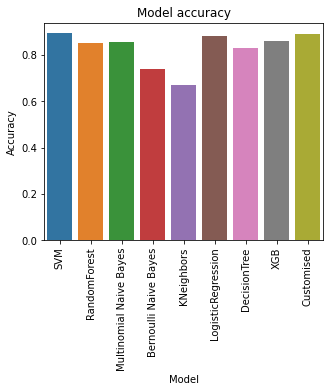

1: Analyze the model
2: Predict the Rating
3: Compare the Models
4: Quit
4


In [50]:
def actions(choice):
    if choice==1: 
        analyze_each()
    elif choice==2:
        predict_rating() 
    else:
        compare_models() 
        #time.sleep(10)
            
print("Sentiment Analysis of Customer Reviews") 
while(True):
    print("1: Analyze the model")
    print("2: Predict the Rating")
    print("3: Compare the Models")
    print("4: Quit")
    choice=int(input())
    if(choice == 4):
        break
    actions(choice)
